# Figure

May 4, 2022

In [1]:
folder = 'fig2-2022-5-4/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars
from algorithms.weight_mirror import WeightMirror

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [4]:
def paper_format(fig,ax,xlabels=None,ylabels=None,labelsize=12,ticksize=10,linewidth=2,ylim=[0,1],figsize=(2.5,2.5)):
    
    """ Format Figure for Paper 8.5 x 11 """
    ax.set_ylim(ylim)
    
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])
    
    ax.xaxis.label.set_size(labelsize)
    ax.yaxis.label.set_size(labelsize)
    ax.tick_params(axis='x', labelsize=ticksize)
    ax.tick_params(axis='y', labelsize=ticksize)
    
    ax.set_title(ax.get_title(),fontsize=labelsize)
    
    """ for small figures """
    if xlabels:
        ax.xaxis.set_major_locator(FixedLocator(xlabels))
        ax.xaxis.set_major_formatter(FixedFormatter(xlabels))
    
    if ylabels:
        ax.yaxis.set_major_locator(FixedLocator(ylabels))
        ax.yaxis.set_major_formatter(FixedFormatter(ylabels))
    
    if ax.get_legend_handles_labels()[1] != []:
        ax.legend(prop={"size":labelsize})
    
    plt.tight_layout()

    return fig,ax

### Train RNN on four targets

Note here that the input is only "on" for 20% of the trial.

In [5]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Part 1 - RFLO across multiple seeds, Scenarios where M is learned

In [ ]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.05,eta_out=0.1,eta_m=0.001,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,sig_m = 0.1, lam_m = 0.00001,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [1,5,7]#,1,12,54,72,81]
overlaps = [0.4]
n_changes = [75]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['covariance1'] = []
stats['covariance2'] = []
stats['covariance3'] = []

stats['corr_w_m'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    
    covariance1_list = []
    covariance2_list = []
    covariance3_list = []
    
    corr_w_m = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """
        """ Calculate F fields Over windows """
        window = 200
        delta = 600
        blocks = np.arange(0,5000,window)
        
        for start in blocks:
            end = start + delta + window
            print('start {} end {} '.format(start,end))
            if end+window > np.max(blocks):
                break

            sim1_pre = Simulation(net1_pre)
            trackvars = TrackVars(net1_pre,apply_to=[]) 
            sim1_pre.run_session(n_trials=window, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
            #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

            """ Train with new decoder """

            sim1_train = Simulation(net1)
            rflo = RFLO(net1,apply_to=['w_rec'],online=False)
            weight_mirror = WeightMirror(net1,apply_to=['w_m']) 
            print('>>APPLY WEIGHT MIRRORING')
            sim1_train.run_session(n_trials=delta, tasks=[task1,task2,task3,task4], learn_alg=[rflo,weight_mirror], probe_types=['h','loss','err'], plot=True, plot_freq=10)

            """ Track activity with new decoder, after training """
            net1_post = RNN(params)
            net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
            net1_post.set_weights(w_out = net1.w_out)
            net1_post.set_weights(w_m = net1.w_m)

            sim1_post = Simulation(net1_post)
            trackvars = TrackVars(net1_post,apply_to=[]) 
            sim1_post.run_session(n_trials=window, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
            
            fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

            fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')

        
        
            F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
            F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

            print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

            Fdata = F_late - F_early

            # separate train and test data from sim1_train
            n_total = len(sim1_train.session_probes['h'])
            n_train = int(0.5 * n_total)
            idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
            idx_test = np.arange(0,n_total)[~idx_train].astype(int)
            #idx_test=idx_train

            h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
            err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

            Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
            Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
            Fpred_w_m = flow_field_predicted(net1.w_m.T,err_train,h_train)

            h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

            corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
            corr1_list.append(corr1)

            corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
            corr2_list.append(corr2)

            corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
            corr3_list.append(corr3)
            
            
            """ keep tack of alignment """
            
            corr_w_m.append(np.corrcoef(net1.w_m.copy().T.ravel(),net1.w_out.copy().ravel())[0,1])

            fig,ax = plt.subplots(1,1)
            plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
            plt.ylim([0,1])
            plt.ylabel('correlation')
            plt.title('Alignment Wout Wm={:.3f}'.format(corr_w_m[-1]))
            plt.show()
        
        
        
        
        
        
#         """ Calculate Covariance """
#         """ Activity During """
#         covariance1 = np.zeros(task1.trial_duration)
#         covariance2 = np.zeros(task1.trial_duration)
#         covariance3 = np.zeros(task1.trial_duration)
        
#         for t_ind in range(1,task1.trial_duration):
#             """ Covariance Before """
#             h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()

#             C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

#             """ Covariance After """
#             h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

#             C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point
            
#             """ Change in Covariance (Measured)"""
#             DeltaC1 = C1_post - C1_pre

#             h1_train = sim1_train.session_probes['h']
#             err1_train = sim1_train.session_probes['err']

#             dW1_w_out = flow_field_predicted(net0.w_out,err1_train,h1_train)
#             dW1_w_out *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
#             dW1_w_out1 = flow_field_predicted(net1.w_out,err1_train,h1_train)
#             dW1_w_out1 *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
#             dW1_w_m = flow_field_predicted(net1.w_m.T,err1_train,h1_train)
#             dW1_w_m *= 0.001 #dW1_w_m/LA.norm(dW1_w_m)

#             h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
#             h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

#             C1_pred_w_out = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out@(h1_pre[:,t_ind-1,:].T))
#             C1_pred_w_out1 = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out1@(h1_pre[:,t_ind-1,:].T))
#             C1_pred_w_m = np.cov(h1_pre[:,t_ind,:].T + dW1_w_m@(h1_pre[:,t_ind-1,:].T))
            
#             """ Change in Covariance (Predicted) """
#             DeltaC1_pred_w_out = C1_pred_w_out - C1_pre
#             DeltaC1_pred_w_out1 = C1_pred_w_out1 - C1_pre
#             DeltaC1_pred_w_m = C1_pred_w_m - C1_pre

#             covariance1[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]
#             covariance2[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]
#             covariance3[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]
            


#             if t_ind == 10:
#                 print('similarity DeltaC1 & DeltaC1_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]))
#                 print('similarity DeltaC1 & DeltaC1_pred_w_out1: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]))
#                 print('similarity DeltaC1 & DeltaC1_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]))
#                 print('\n')

#             CTRL_h1_pre = np.cov(h1_pre[:,t_ind,:].T)
#             CTRL_h1_post = np.cov(h1_post[:,t_ind,:].T)
#             CTRL_dW1_w_out_h1_post = np.cov(dW1_w_out@(h1_post[:,t_ind,:].T))
#             CTRL_dW1_w_out1_h1_post = np.cov(dW1_w_out1@(h1_post[:,t_ind,:].T))
#             CTRL_dW1_w_m_h1_post = np.cov(dW1_w_m@(h1_post[:,t_ind,:].T))

#             if t_ind == 10:
#                 print('>> CTRL DeltaC1 & CTRL_h1_pre: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_pre.ravel())[0,1]))
#                 print('>> CTRL DeltaC1 & CTRL_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_post.ravel())[0,1]))
#                 print('>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out_h1_post.ravel())[0,1]))
#                 print('>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out1_h1_post.ravel())[0,1]))
#                 print('>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_m_h1_post.ravel())[0,1]))

#                 print('\n')
                
#         covariance1_list.append(covariance1)
#         covariance2_list.append(covariance2)
#         covariance3_list.append(covariance3)
        
#         fig,ax = plt.subplots(1,1)
#         plt.plot(np.asarray(covariance1).T,'o-',label='cov Wout0',color='teal')
#         plt.plot(np.asarray(covariance2).T,'o-',label='cov Wout1',color='darkblue')
#         plt.plot(np.asarray(covariance3).T,'o-',label='cov M',color='tomato')
#         plt.legend()
#         plt.xlabel('timestep')
#         plt.ylabel('corr pred measured dCov')
#         plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    
    stats['corr_w_m'].append(corr_w_m)
    #stats['corrcoef'].append(corrcoef_list)
#     stats['covariance1'].append(covariance1_list)
#     stats['covariance2'].append(covariance2_list)
#     stats['covariance3'].append(covariance3_list)


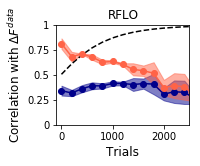

In [56]:
save = True
paper = True

ind = np.where(blocks < blocks[-1]-window-delta)[0]
x = blocks[ind]

mn1 = np.mean(np.asarray(stats['corr1']).T,axis=1)
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
std1 = np.std(np.asarray(stats['corr1']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)

fig,ax = plt.subplots(1,1)

plt.plot(x,np.mean(np.asarray(stats['corr_w_m']).T,axis=1),'--',color='k')

#plt.plot(x,mn1,'o-',color='teal')
plt.plot(x,mn2,'o-',color='darkblue')
plt.plot(x,mn3,'o-',color='tomato')
#plt.fill_between(x,mn1-std1,mn1+std1,alpha=0.5,color='teal')
plt.fill_between(x,mn2-std2,mn2+std2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-std3,mn3+std3,alpha=0.5,color='tomato')



plt.title('RFLO')
plt.ylabel('Correlation with '+r'$\Delta F^{data}$')
plt.xlabel('Trials')
plt.ylim([0,1.1])
plt.xlim([-100,2500])

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],linewidth=2,ylim=[0,1],figsize=(2.5,3))

plt.show()

if save:
    fig.savefig(folder+'rflo-weight-mirror.pdf')

# Part 2 - RFLO across multiple seeds, Scenarios where Wfb alone is learned

18it [00:00, 179.29it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb831ed4048>


2500it [00:07, 313.43it/s]
99it [00:00, 982.67it/s]

M norm: 1.06	 M angle: 0.61, 0 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.06	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.41

500it [00:00, 1011.93it/s]
4000it [00:11, 359.07it/s]
500it [00:00, 1033.18it/s]


AR early fit 0.962, late fit 0.973


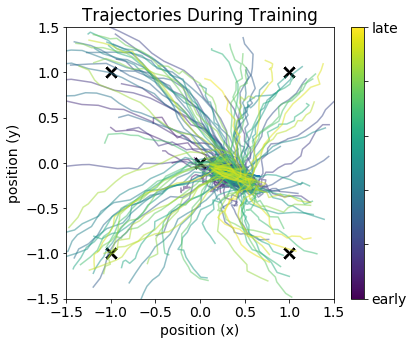

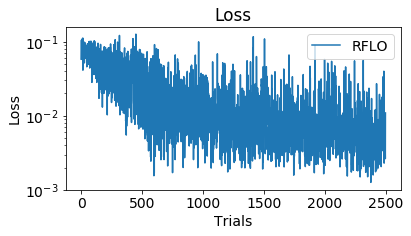

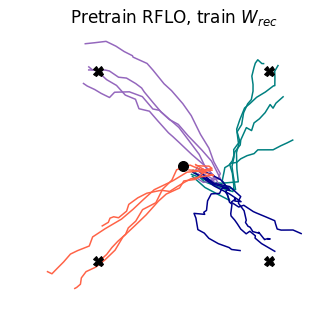

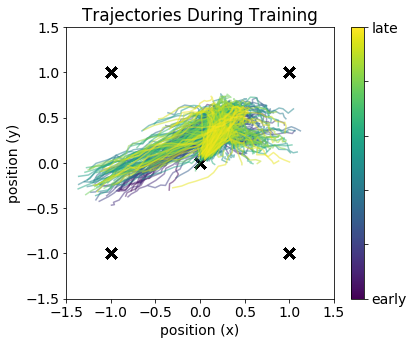

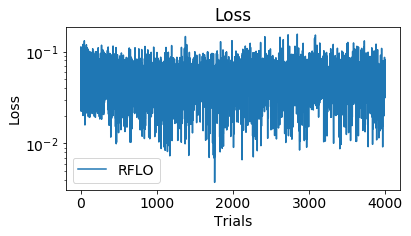

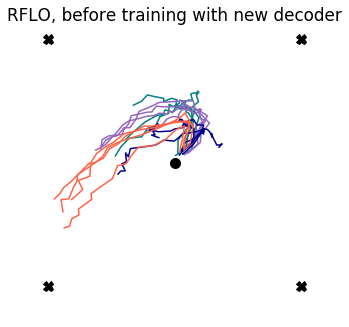

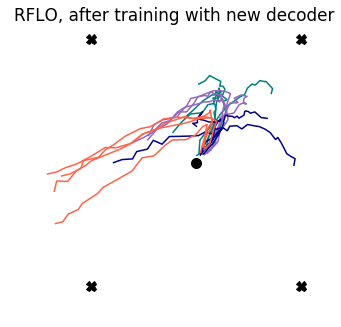

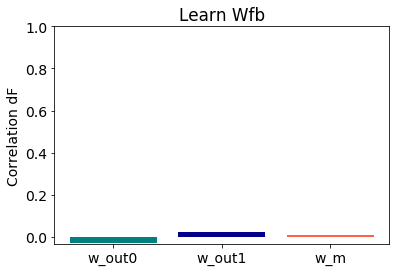

similarity DeltaC1 & DeltaC1_pred_w_out: -0.065
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.050
similarity DeltaC1 & DeltaC1_pred_w_m: 0.264


>> CTRL DeltaC1 & CTRL_h1_pre: -0.082
>> CTRL DeltaC1 & CTRL_h1_post: 0.520
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: -0.038
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.053
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.188




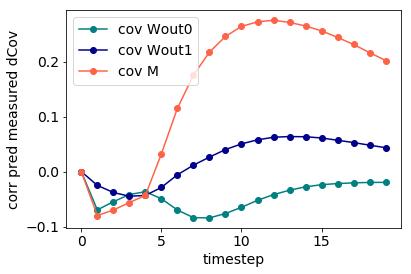

M norm: 1.10	 M angle: 0.60, 0 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.71	 w_out vs. w_m angle: 0.29

500it [00:02, 174.58it/s]
4000it [00:17, 231.24it/s]
500it [00:00, 1021.55it/s]


AR early fit 0.963, late fit 0.980


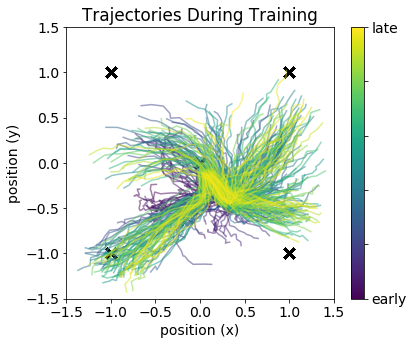

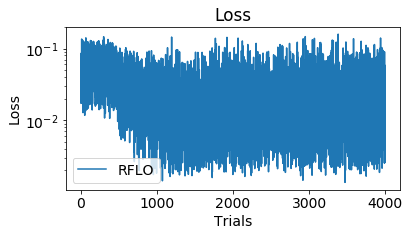

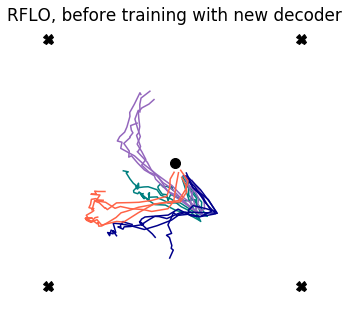

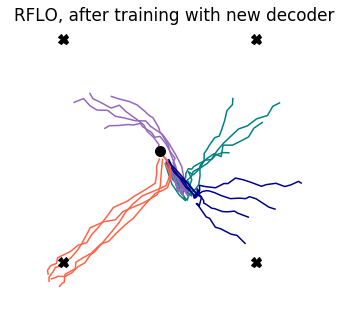

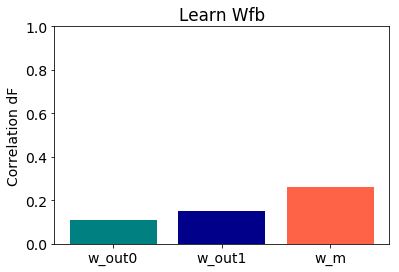

similarity DeltaC1 & DeltaC1_pred_w_out: 0.172
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.279
similarity DeltaC1 & DeltaC1_pred_w_m: 0.669


>> CTRL DeltaC1 & CTRL_h1_pre: 0.259
>> CTRL DeltaC1 & CTRL_h1_post: 0.942
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.134
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.186
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.485




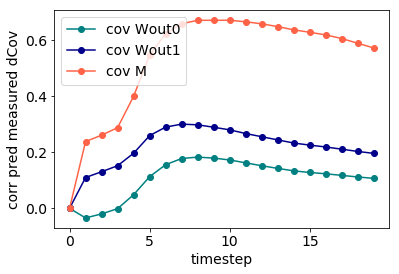

69it [00:00, 688.20it/s]

M norm: 1.09	 M angle: 0.60, 4 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.31

500it [00:00, 844.42it/s]
4000it [00:13, 307.39it/s]
500it [00:00, 1041.18it/s]


AR early fit 0.960, late fit 0.967


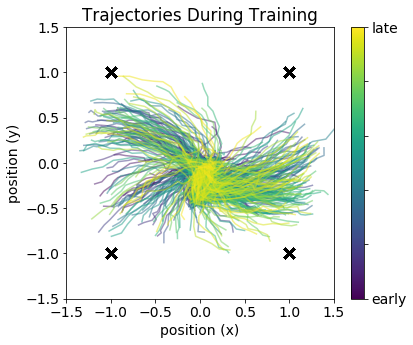

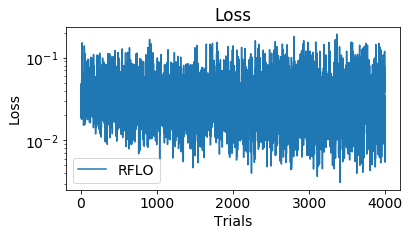

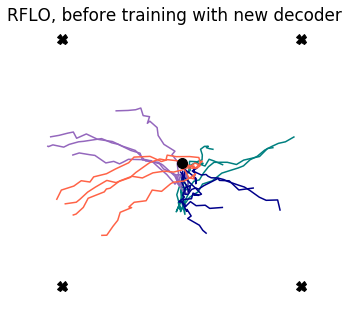

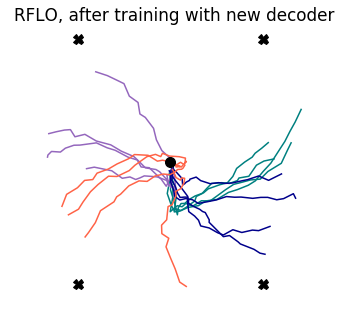

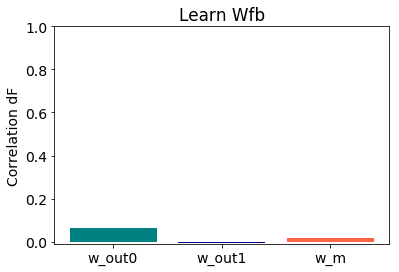

similarity DeltaC1 & DeltaC1_pred_w_out: 0.065
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.201
similarity DeltaC1 & DeltaC1_pred_w_m: 0.427


>> CTRL DeltaC1 & CTRL_h1_pre: 0.033
>> CTRL DeltaC1 & CTRL_h1_post: 0.634
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.106
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.165
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.274




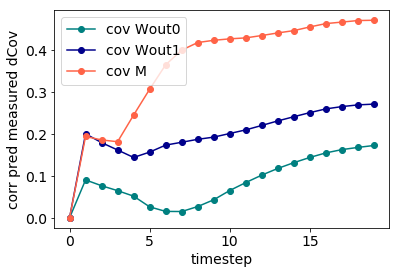

In [119]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec','w_fb'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [0,1,12]#,54]#,54,72,81]
overlaps = [0.6]
n_changes = [50]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['covariance1'] = []
stats['covariance2'] = []
stats['covariance3'] = []

stats['corr_w_fb_w_m'] = []
stats['corr_w_fb_w_out'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    
    covariance1_list = []
    covariance2_list = []
    covariance3_list = []
    
    corr_w_fb_w_m = []
    corr_w_fb_w_out = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        
        corr_w_fb_w_m.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_fb'],online=False)
        sim1_train.run_session(n_trials=4000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(),w_fb = net1.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        # correlation after learning
        corr_w_fb_w_m.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
        plt.ylim(top=1)
        plt.ylabel('Correlation dF')
        plt.title('Learn Wfb')
        plt.show()
        
        
        
        
        
        
        """ Calculate Covariance """
        """ Activity During """
        covariance1 = np.zeros(task1.trial_duration)
        covariance2 = np.zeros(task1.trial_duration)
        covariance3 = np.zeros(task1.trial_duration)
        
        for t_ind in range(1,task1.trial_duration):
            """ Covariance Before """
            h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()

            C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

            """ Covariance After """
            h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

            C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point
            
            """ Change in Covariance (Measured)"""
            DeltaC1 = C1_post - C1_pre

            h1_train = sim1_train.session_probes['h']
            err1_train = sim1_train.session_probes['err']

            dW1_w_out = flow_field_predicted(net0.w_out,err1_train,h1_train)
            dW1_w_out *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW1_w_out1 = flow_field_predicted(net1.w_out,err1_train,h1_train)
            dW1_w_out1 *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW1_w_m = flow_field_predicted(net1.w_m.T,err1_train,h1_train)
            dW1_w_m *= 0.001 #dW1_w_m/LA.norm(dW1_w_m)

            h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
            h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

            C1_pred_w_out = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out@(h1_pre[:,t_ind-1,:].T))
            C1_pred_w_out1 = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out1@(h1_pre[:,t_ind-1,:].T))
            C1_pred_w_m = np.cov(h1_pre[:,t_ind,:].T + dW1_w_m@(h1_pre[:,t_ind-1,:].T))
            
            """ Change in Covariance (Predicted) """
            DeltaC1_pred_w_out = C1_pred_w_out - C1_pre
            DeltaC1_pred_w_out1 = C1_pred_w_out1 - C1_pre
            DeltaC1_pred_w_m = C1_pred_w_m - C1_pre

            covariance1[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]
            covariance2[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]
            covariance3[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]
            


            if t_ind == 10:
                print('similarity DeltaC1 & DeltaC1_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]))
                print('similarity DeltaC1 & DeltaC1_pred_w_out1: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]))
                print('similarity DeltaC1 & DeltaC1_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]))
                print('\n')

            CTRL_h1_pre = np.cov(h1_pre[:,t_ind,:].T)
            CTRL_h1_post = np.cov(h1_post[:,t_ind,:].T)
            CTRL_dW1_w_out_h1_post = np.cov(dW1_w_out@(h1_post[:,t_ind,:].T))
            CTRL_dW1_w_out1_h1_post = np.cov(dW1_w_out1@(h1_post[:,t_ind,:].T))
            CTRL_dW1_w_m_h1_post = np.cov(dW1_w_m@(h1_post[:,t_ind,:].T))

            if t_ind == 10:
                print('>> CTRL DeltaC1 & CTRL_h1_pre: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_pre.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out1_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_m_h1_post.ravel())[0,1]))

                print('\n')
                
        covariance1_list.append(covariance1)
        covariance2_list.append(covariance2)
        covariance3_list.append(covariance3)
        
        fig,ax = plt.subplots(1,1)
        plt.plot(np.asarray(covariance1).T,'o-',label='cov Wout0',color='teal')
        plt.plot(np.asarray(covariance2).T,'o-',label='cov Wout1',color='darkblue')
        plt.plot(np.asarray(covariance3).T,'o-',label='cov M',color='tomato')
        plt.legend()
        plt.xlabel('timestep')
        plt.ylabel('corr pred measured dCov')
        plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)
    stats['covariance1'].append(covariance1_list)
    stats['covariance2'].append(covariance2_list)
    stats['covariance3'].append(covariance3_list)
    
    stats['corr_w_fb_w_m'].append(corr_w_fb_w_m)
    stats['corr_w_fb_w_out'].append(corr_w_fb_w_out)


In [94]:
np.asarray(stats['corr_w_fb_w_m']).shape

(3, 2)

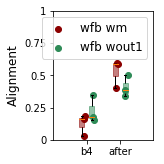

In [140]:
save = True
paper = True

""" alignment of w_fb and w_m """
fig,ax=plt.subplots(1,1,figsize=(3,3))
pos1 = 1
pos2 = 2
dx = 0.15
plt.scatter([pos1]*3+0.1*np.random.rand(3)-dx,np.asarray(stats['corr_w_fb_w_m'])[:,0],color='darkred',label='wfb wm')
plt.scatter([pos2]*3+0.1*np.random.rand(3)-dx,np.asarray(stats['corr_w_fb_w_m'])[:,1],color='darkred')
plt.scatter([pos1]*3+0.1*np.random.rand(3)+dx,np.asarray(stats['corr_w_fb_w_out'])[:,0],color='seagreen',label='wfb wout1')
plt.scatter([pos2]*3+0.1*np.random.rand(3)+dx,np.asarray(stats['corr_w_fb_w_out'])[:,1],color='seagreen')
plt.boxplot(np.asarray(stats['corr_w_fb_w_m']),positions=[pos1-dx,pos2-dx],patch_artist=True,boxprops=dict(facecolor='darkred', color='darkred',alpha=0.5))
plt.boxplot(np.asarray(stats['corr_w_fb_w_out']),positions=[pos1+dx,pos2+dx],patch_artist=True,boxprops=dict(facecolor='seagreen', color='seagreen',alpha=0.5))
plt.ylim([0,1])
plt.xlim([0,3])
ax.set_xticks([1,2])
ax.set_xticklabels(['b4','after'])
plt.legend()
plt.ylabel('Alignment')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ylim=[0,1],figsize=(2.5,2.5))

plt.show()

if save:
    fig.savefig(folder + 'rflo-align-boxplot-learn-wfb.pdf')


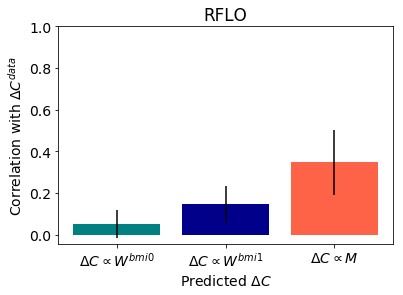

In [142]:
""" use covariance calculation to plot summary """
paper = False
save = False

fig,ax=plt.subplots(1,1)

""" take mean and std """
mn1 = np.mean(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
mn2 = np.mean(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
mn3 = np.mean(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)
std1 = np.std(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
std2 = np.std(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
std3 = np.std(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)

plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$\Delta C \propto W^{bmi0}$',r'$\Delta C \propto W^{bmi1}$',r'$\Delta C \propto M$'],color=['teal','darkblue','tomato'])

plt.title('RFLO')
plt.ylabel('Correlation with '+r'$\Delta C^{data}$')
plt.xlabel('Predicted '+r'$\Delta C$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],linewidth=2,ylim=[0,1],figsize=(2.5,2.5))

plt.show()

if save:

    fig.savefig(folder+'rflo-cov-learn-wfb.pdf')

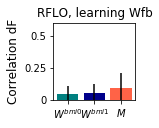

In [144]:
paper = True
save  = False

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]

fig,ax = plt.subplots(1,1)

plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$'],color=['teal','darkblue','tomato'])

plt.title('RFLO, learning Wfb')
plt.ylabel('Correlation dF') #with '+r'$\Delta F^{data}$
#plt.xlabel('Predicted '+r'$\Delta F$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],linewidth=2,ylim=[0,0.6],figsize=(2,2.25))

plt.show()

if save:
    fig.savefig(folder+'rflo-dF-learn-wfb.pdf')